# Analyze consensus motif
The third output from the computational pipeline is a fasta file of the best predicted promoter for each input sequence. For more details about how robust these predictions are, see Section 2 of `inspect_BioProspector_results.ipynb`. 

Given a fasta file of best predictions from a given set of input settings for the pipeline, we next want to 
1. Visualize the consensus motif
1. Score consensus motif PSSM matches to hexamers of predicted promoters
1. Analyze occurences of the consensus motif across the genome

For the above analyses, we use the BioProspector outputs from the top 3% of expressed genes across all conditions. However this computational framework makes it easy to produce outputs for several different top percentage threshold. To demonstrate, we compare a range of outputs from different top% thresholds here.

4. Compare consensus motifs from different top percentage thresholds

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import genbank_utils as gu
import consensus_viz_utils as cu

# 1. Visualize the consensus motif

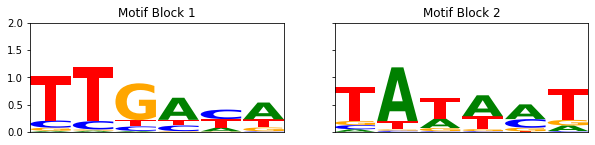

In [2]:
# Load BioPropsector output from predicting promoters from the top 3% of expressed loci
selection_f = "example_outdir/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1604734841_SELECTION.fa"
motif_blocks, m1, m2 = cu.build_2Bmotif_from_selection_file(selection_f)

# 2. Score consensus motif PSSM matches to hexamers of predicted promoters
The above motif was derived from the first 6 and final 6 bases of each predicted promoter from the set of top loci. Here, we simply apply this the Position Specific Scoring Matrix (PSSM) back to the inputs to gauge in general, how well does this motif match the inputs. If most inputs receive relatively high scores, it suggests that there was a clearer signal that was found among the promoter input sequences provided and the consensus summarizes the signal well across the top loci promoter predcitions. Lower scores indicate that the consensus didn't summarize the predictions very well (perhaps the signal it found wasn't very clear, there were multiple competing signals, or maybe individual inputs didn't have this particular promoter structure (possibly a different sigma factor structure)). 

In [3]:
hex_score_df = cu.score_predictions_to_motif(motif_blocks, m1, m2)
hex_score_df.head()

,locus_tag,desc,motif_block,hex1,hex1_score,hex2,hex2_score,total_score
0,EQU24_RS02895,EQU24_RS02895||exosortase system-associated pr...,TTGACAACATTCAACCTTTAGGCTATTGT,TTGACA,8.353386,TATTGT,5.705159,14.058544
1,EQU24_RS02970,EQU24_RS02970|pqqA|pyrroloquinoline quinone pr...,TTGCTTTGCCTAAATTATCGTCGTATACT,TTGCTT,5.215478,TATACT,7.691535,12.907013
2,EQU24_RS03495,EQU24_RS03495||cold-shock protein,TTGACTTTGGGGAAATAAGGCATAGAAT,TTGACT,7.306080,TAGAAT,5.739588,13.045668
3,EQU24_RS07185,EQU24_RS07185||glutamate--ammonia ligase,TTGTAATTGAGATCAATTAGTTGCTTATAT,TTGTAA,5.040391,TTATAT,3.933783,8.974174
4,EQU24_RS07390,EQU24_RS07390|rpmI|50S ribosomal protein L35,CTCAAGGAAACTTACTATTTTTAATCG,CTCAAG,-0.801626,TAATCG,3.369716,2.568090


In this dataframe, `hex1_score` and `hex2_score` represent this predictions log odds score (how well it matches) to the consensus PSSM above. The `total_score` is the sum of `hex1_score` and `hex2_score`. Higher scores indicate better matches to the consensus.

In [4]:
# scatter plot of hex1 vs hex 2
scatter = alt.Chart(
    hex_score_df,
).mark_point().encode(
    x=alt.X('hex1_score:Q',axis=alt.Axis(title="-35 Consensus Match")),
    y=alt.Y('hex2_score:Q',axis=alt.Axis(title="-10 Consensus Match")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
).properties(
    width=200,
    height=200
).interactive()

# stripplot showing total score (hex1 + hex2)
stripplot = alt.Chart(
    hex_score_df,
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y(
        'total_score:Q',
        axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color(
        'total_score:Q',
        scale=alt.Scale(scheme='viridis'),
        sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).properties(height=200, width=50
).interactive()

# horizontally concat plots
combo = alt.hconcat(
    scatter, 
    stripplot,
    title=f"Consensus motif match scores to promoter predictions"
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    anchor='middle',
    fontSize=20
)

combo

alt.HConcatChart(...)

#### Interactive plot! 
* Hover over points to see which prediction they correspond to
* Zoom and pan to investigate more closely

Quick plot comparing individual predictions match to both the first (-35) and second (-10) promoter blocks. From the left panel, we notice more predictions had closer matches to the -35 consensus while a few had close matches to the -10 consensus. No predictions were quite perfect in both the -35 and -10 positions. The panel on the right displays which predictions exhibited the overall highest scores.

# 3. Analyze occurences of the consensus motif across the genome
To help convince ourselves that the consensus we found was meaningful, we wanted to make sure that this signal was specific to promoter regions. In particular, we searched for matches to the consensus across the entire _M. buryatense genome_ and recorded the position of each match. Positions were sorted into 4 categories:
1. *`in gene`*: Located inside a feature annotation
1. *`intergenic`*: Beyond 300bp of a feature start coordinate, not inside a feature
1. *`<300 to ATG`*: Within 300bp of a feature start coordinate (including matches from `<100 to ATG`)
1. *`<100 to ATG`*: Within 100bp of a feature start coordinate (usually an ATG, the translation start site)

In the following analysis, we count the number of PSSM matches that fall into each category and normalize by the total number of genome positions that belong to each category. This normalization indicates if PSSM matches tend to be overrepresented in regions closely upstream of translation start sites (likely promoter regions)


## Load genome and feature coords from genbank

In [5]:
gbFile_5G = 'data/5GB1c_sequence.gb'

GENOME_FWD, GENOME_REV,GENOME_LEN = gu.get_genome_fwd_rev_len(gbFile_5G)
print("Genome length:", GENOME_LEN, "bps")
print(GENOME_FWD[:10])
print(GENOME_REV[-10:])

# put into a tuple for a later function that expects this format
genomes = [
    ('genome_fwd','genome_fwd',GENOME_FWD),
    ('genome_rev','genome_rev',GENOME_REV)
]

Genome length: 4998879 bps
ATGAGTGCAC
GTGCACTCAT


In [6]:
# extract tuples of just the feature coordinates from the genbank object
pos_feat_coords, neg_feat_coords = gu.get_pos_neg_relative_feature_coords(gbFile_5G, GENOME_LEN)

### Build arrays for the "distance to feature" and "nearest feature"
For every position in the genome, record: 
* how far is it to the nearest feature start coordinate on the same strand
* what is the next nearest feature ID to this position in the genome

Use these arrays to count the baseline number of positions in the genome that fall into each category (we'll use this later to normalize PSSM match counts)

In [7]:
pos_dist_array,pos_nearest_feat_array = cu.build_feature_distance_index(pos_feat_coords,GENOME_LEN)
neg_dist_array,neg_nearest_feat_array = cu.build_feature_distance_index(neg_feat_coords,GENOME_LEN)

# make category df for all positions in the gneome to get baseline counts
# of each category
baseline_cat_df = cu.build_genome_position_category_df(pos_dist_array, neg_dist_array)
baseline_cat_df.head()

,cat,pos_count,neg_count,total
0,in gene,2017571,2133177,4150748
1,100:300 to ATG,206887,208575,415462
2,<100 to ATG,140842,144902,285744
3,intergenic,2633579,2512225,5145804
4,<300 to ATG,347729,353477,701206


### Search for the consensus across the genome
Since BioProspector searched for 2-block motif patterns with a spacer anywhere from 15-18bp, we will similarly consider consensus matches with variable spacing. So first, we will construct a PSSM that combines the -35 and -10 blocks by insert a matrix of 0's (neutral odds) between the blocks. The matrix will be 4x[15,16,17,18]. We'll search for all of these PSSMs across the genome and record all matches (genome positions with a log odds score > 0, so sequences that looks more like the consensus than random). Based on the match position's end coordinate, we will assign each match to one of the 4 genome categories outlined above.

In [8]:
# from the consensus motif blocks, build variably spaced PSSMs (with 15-18bp spacers)
var_spaced_motifs = cu.build_dict_of_motifs_to_try(m1, m2)

In [9]:
# search for PSSM matches in the forward and reverse direction
motif_match_df = cu.find_and_score_motifs_in_seqs(var_spaced_motifs,genomes,{})
motif_match_df = cu.add_genome_category_to_pssm_matches(
    motif_match_df,
    pos_dist_array,
    pos_nearest_feat_array,
    neg_dist_array,
    neg_nearest_feat_array)
motif_match_df.head()

Adding categories to pssm matches...


,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?,motif_loc,nearest_feat
0,genome_fwd,genome_fwd,0.009014,8,4998879,15,ACTCTGGAACAACTGTCTCGCTAAACT,False,in gene,EQU24_RS00005
1,genome_fwd,genome_fwd,4.560510,20,4998879,15,CTGTCTCGCTAAACTTGAAAATGAAAT,False,in gene,EQU24_RS00005
2,genome_fwd,genome_fwd,4.211860,34,4998879,15,TTGAAAATGAAATTTCTTCCTCGGAAT,False,in gene,EQU24_RS00005
3,genome_fwd,genome_fwd,0.515077,50,4998879,15,TTCCTCGGAATTCAGCACCTGGATTAG,False,in gene,EQU24_RS00005
4,genome_fwd,genome_fwd,2.806593,91,4998879,15,TCGAAACCGATGGACAAATCAAGTTAT,False,in gene,EQU24_RS00005


### Analyze the number of matches in each genome category

In [10]:
motif_match_cat_df = cu.analyze_motif_matches_across_genome(
    motif_match_df,
    baseline_cat_df)

motif_match_cat_df

Normalizing pssm match counts


,cat,pos_count,neg_count,total,pssm_match_count,match_perc
0,in gene,2017571,2133177,4150748,481616,0.116031
1,100:300 to ATG,206887,208575,415462,69177,0.166506
2,<100 to ATG,140842,144902,285744,62479,0.218654
3,intergenic,2633579,2512225,5145804,692056,0.134489
4,<300 to ATG,347729,353477,701206,131656,0.187757


This "category dataframe" shows the total number of positions in each category in the `total` column (a sum of the `pos_count` and `neg_count` columns). The `pssm_match_count` column is the count of PSSM matches. The `match_perc` column is the `pssm_match_count` divided by the `total`. This normalization is necessary because the total number of positions in the genome that are "intergenic" or "in gene" is far greater than the number of positions within 100bp of a start coordinate, and thus there are many more chances for matches to occur. Here, we're interested to see if there's an enrichment for relatively more matches occuring in promoter regions (areas closely upstream of features), which would suggest the motif we found with BioProspector indeed is enriched in these areas and not a random, non-specific signal. 

### Visualize all normalized PSSM counts

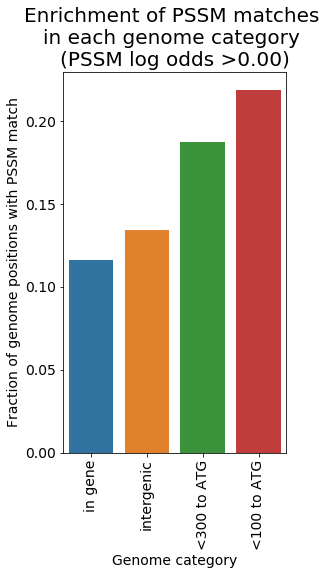

In [11]:
cu.genome_category_normed_bar_v(motif_match_cat_df)

### Analyze the number of high scoring matches in each genome category
While the above chart indeed shows an enrichment of PSSM matches to regions closely upstream of features, many of these matches are relatively low quality (low log-odds score). Next, we simply filter the motif match data frame to only extremely high scoring matches (log-odds above a threshold of 12). 

In [12]:
# set a log odds score threshold
threshold=12
top_motif_match_df = motif_match_df[motif_match_df['score']>threshold]

# analyze categories for top matches only
top_motif_match_cat_df = cu.analyze_motif_matches_across_genome(
    top_motif_match_df,
    baseline_cat_df)

top_motif_match_cat_df

Normalizing pssm match counts


,cat,pos_count,neg_count,total,pssm_match_count,match_perc
0,in gene,2017571,2133177,4150748,435,0.000105
1,100:300 to ATG,206887,208575,415462,140,0.000337
2,<100 to ATG,140842,144902,285744,167,0.000584
3,intergenic,2633579,2512225,5145804,748,0.000145
4,<300 to ATG,347729,353477,701206,307,0.000438


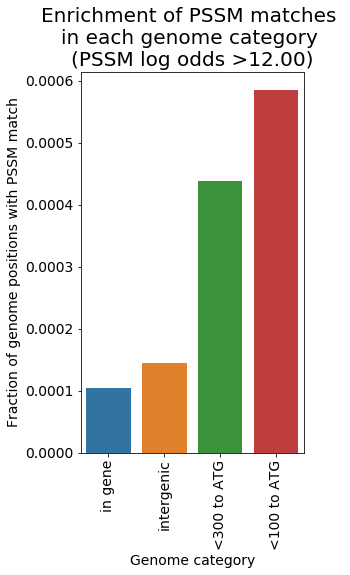

In [14]:
cu.genome_category_normed_bar_v(top_motif_match_cat_df,threshold=threshold)

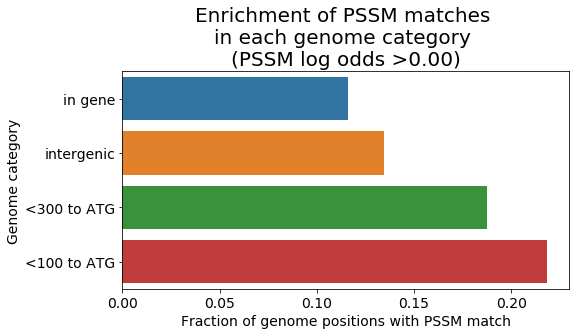

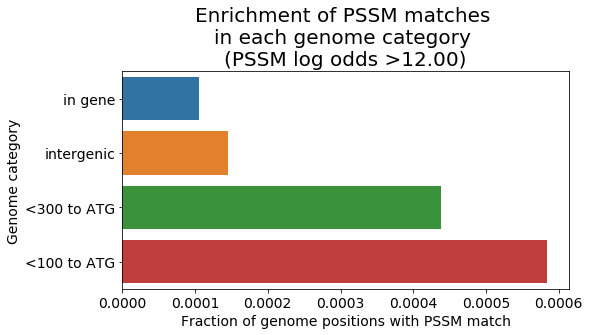

In [15]:
# horizontal versions
cu.genome_category_normed_bar_h(motif_match_cat_df)
cu.genome_category_normed_bar_h(top_motif_match_cat_df,threshold=threshold)

Indeed, when only considering extremely strong matches to the consensus motif, the enrichment in upstream regions (`<100 to ATG` and `<300 to ATG`) is amplified

# 4. Compare consensus motifs from different top percentage thresholds
While the above analyses use the top 3% of expressed genes, it may be useful to compare results for different percentage thresholds. Here we examine and compare the consensus results for the top 1,2,3,4,5,6,10,and 20% thresholds.

In [16]:
# dictionary of various biopropsector pipeline outputs
f_dict = {
    1:'n1_outdir/loci_in_top_1perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952145_SELECTION.fa',
    2:'n2_outdir/loci_in_top_2perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599038857_SELECTION.fa',
    3:'n3_outdir/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952202_SELECTION.fa',
    4:'n4_outdir/loci_in_top_4perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039044_SELECTION.fa',
    5:'n5_outdir/loci_in_top_5perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952321_SELECTION.fa',
    6:'n6_outdir/loci_in_top_6perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039246_SELECTION.fa',
    10:'n10_outdir/loci_in_top_10perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952515_SELECTION.fa',
    20:'n20_outdir/loci_in_top_20perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598953063_SELECTION.fa'
}

In [17]:
def compare_consensus_motifs(f_dict,threshold=12):
    '''
    Given a file dict of bioprospector outputs:
    1. determine the consensus motif
    2. score the consensus against the input promoter predictions
    3. search for the consensus across both strands of the genome
    
    '''
    # save various intermediate dfs to concat at the end
    hex_score_dfs = []
    motif_match_dfs = []
    motif_match_cat_dfs = []
    top_motif_match_cat_dfs = []
    
    # loop through all selection files for different n-percent thresholds
    for nperc in f_dict:
        print(f"\nTop {nperc}% consensus")
        # extract the consensus motif in 2 blocks
        motif_blocks, m1, m2 = cu.build_2Bmotif_from_selection_file(f_dict[nperc])
        
        hex_score_df = cu.score_predictions_to_motif(motif_blocks, m1, m2)
        # add nperc column
        hex_score_df['nperc'] = nperc
        hex_score_dfs.append(hex_score_df)

        # while we have a specific consensus motif block for this file, search
        # for it across the genome
        # from the consensus motif blocks, build variably spaced PSSMs (with 15-18bp spacers)
        var_spaced_motifs = cu.build_dict_of_motifs_to_try(m1, m2)

        # search for PSSM matches in the forward and reverse direction
        motif_match_df = cu.find_and_score_motifs_in_seqs(var_spaced_motifs,genomes,{})
        # add the genome category
        motif_match_df = cu.add_genome_category_to_pssm_matches(motif_match_df,
                                        pos_dist_array,
                                        pos_nearest_feat_array,
                                        neg_dist_array,
                                        neg_nearest_feat_array)
        # add nperc column
        motif_match_df['nperc'] = nperc
        motif_match_dfs.append(motif_match_df)
        
        motif_match_cat_df = cu.analyze_motif_matches_across_genome(
            motif_match_df,
            baseline_cat_df)
        # add nperc column
        motif_match_cat_df['nperc'] = nperc
        motif_match_cat_dfs.append(motif_match_cat_df)
        
        
        # also calculate enrichment for the top scoring matches
        print(f"Calculating for top scoring matches (threshold={threshold})")
        top_motif_match_df = motif_match_df[motif_match_df['score']>threshold]

        top_motif_match_cat_df = cu.analyze_motif_matches_across_genome(
            top_motif_match_df,
            baseline_cat_df)
        # add nperc column
        top_motif_match_cat_df['nperc'] = nperc
        top_motif_match_cat_dfs.append(top_motif_match_cat_df)
    
    # concat all dfs into combined version
    print("Concatting final dfs")
    all_hex_df = pd.concat(hex_score_dfs)
    all_motif_match_df = pd.concat(motif_match_dfs)
    all_motif_match_cat_df = pd.concat(motif_match_cat_dfs)
    all_top_motif_match_cat_df = pd.concat(top_motif_match_cat_dfs)
    
    return all_hex_df, all_motif_match_df, all_motif_match_cat_df, all_top_motif_match_cat_df


Top 1% consensus


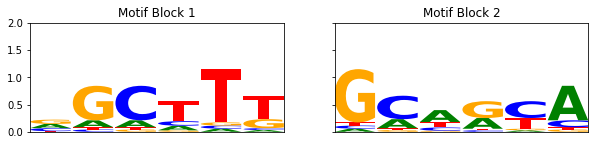

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 2% consensus


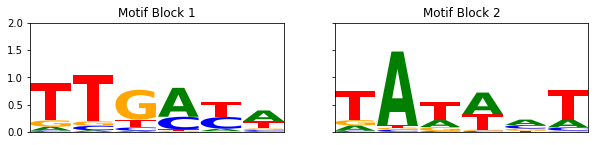

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 3% consensus


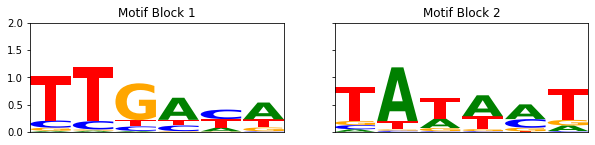

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 4% consensus


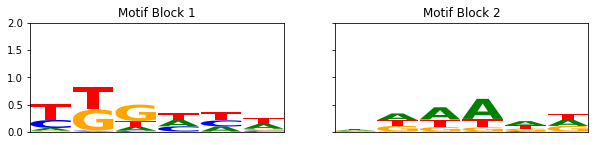

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 5% consensus


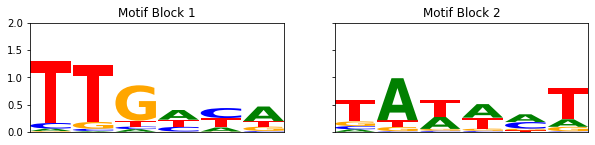

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 6% consensus


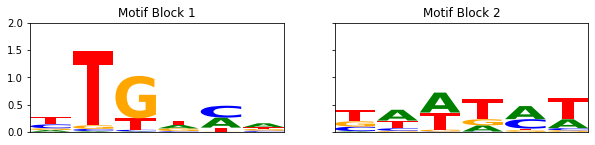

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 10% consensus


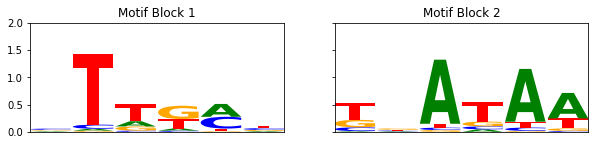

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 20% consensus


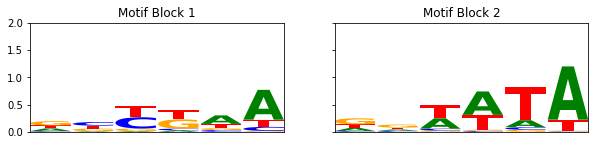

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [18]:
all_hex_df, \
all_motif_match_df, \
all_motif_match_cat_df, \
all_top_motif_match_cat_df = compare_consensus_motifs(f_dict)

In [19]:
all_hex_df.head()

,locus_tag,desc,motif_block,hex1,hex1_score,hex2,hex2_score,total_score,nperc
0,EQU24_RS12095,EQU24_RS12095||cytochrome c,CGCTTTATCTCAAAATCCTAGCGAAACA,CGCTTT,7.692483,GAAACA,6.110931,13.803413,1
1,EQU24_RS12525,EQU24_RS12525|ssrA|transfer-messenger RNA,GAATTTAATTGTTAATATCGCGCAACA,GAATTT,3.534054,GCAACA,7.489443,11.023497,1
2,EQU24_RS16195,EQU24_RS16195||hypothetical protein,AGCATTACCCTAAAATGACCGCGCGAAGTA,AGCATT,6.062433,GAAGTA,6.110931,12.173364,1
3,EQU24_RS18140,EQU24_RS18140|moxF|PQQ-dependent dehydrogenase...,CGCTTTTCCCGTCATCTGGGTGCTGTA,CGCTTT,7.692483,GCTGTA,6.351939,14.044422,1
4,EQU24_RS18355,EQU24_RS18355||hypothetical protein,GGCTTGACGGCGGCTATCCCTGCCGCC,GGCTTG,6.799398,GCCGCC,3.945122,10.744520,1


In [20]:
all_motif_match_df.head()

,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?,motif_loc,nearest_feat,nperc
0,genome_fwd,genome_fwd,4.309251,43,4998879,15,AAATTTCTTCCTCGGAATTCAGCACCT,False,in gene,EQU24_RS00005,1
1,genome_fwd,genome_fwd,3.320483,66,4998879,15,ACCTGGATTAGACCTTTGCAGGCAATC,False,in gene,EQU24_RS00005,1
2,genome_fwd,genome_fwd,0.666263,78,4998879,15,CCTTTGCAGGCAATCGAAACCGATGGA,False,in gene,EQU24_RS00005,1
3,genome_fwd,genome_fwd,3.001706,129,4998879,15,CGGTTTGTGCTGGATTGGGTAAAAGAA,False,in gene,EQU24_RS00005,1
4,genome_fwd,genome_fwd,0.634690,153,4998879,15,GAACATCATTTCGCCAAACTGGAAGAA,False,in gene,EQU24_RS00005,1


In [21]:
all_motif_match_cat_df.head()

,cat,pos_count,neg_count,total,pssm_match_count,match_perc,nperc
0,in gene,2017571,2133177,4150748,674514,0.162504,1
1,100:300 to ATG,206887,208575,415462,65080,0.156645,1
2,<100 to ATG,140842,144902,285744,44618,0.156147,1
3,intergenic,2633579,2512225,5145804,811543,0.157710,1
4,<300 to ATG,347729,353477,701206,109698,0.156442,1


In [22]:
all_top_motif_match_cat_df.head()

,cat,pos_count,neg_count,total,pssm_match_count,match_perc,nperc
0,in gene,2017571,2133177,4150748,631,0.000152,1
1,100:300 to ATG,206887,208575,415462,43,0.000103,1
2,<100 to ATG,140842,144902,285744,39,0.000136,1
3,intergenic,2633579,2512225,5145804,805,0.000156,1
4,<300 to ATG,347729,353477,701206,82,0.000117,1


### Visualize PSSM scores against input sequences

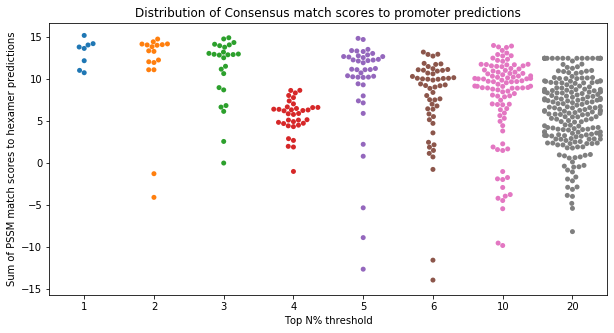

In [23]:
fig = plt.figure(figsize=(10,5))
sns.swarmplot(data=all_hex_df, x='nperc',y='total_score')
plt.xlabel("Top N% threshold")
plt.ylabel("Sum of PSSM match scores to hexamer predictions")
plt.title("Distribution of Consensus match scores to promoter predictions")
plt.show()

In [24]:
stripplot = alt.Chart(
    all_hex_df,
    #title=f"Prediction consensus matches"
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y('total_score:Q',axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
    column=alt.Column(
        'nperc:N', 
        header=alt.Header(
            labelFontSize=16,
            labelAngle=0,
            titleOrient='top',
            labelOrient='bottom',
            labelAlign='center',
            labelPadding=25,
       ),
    ),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
).properties(height=200, width=100)

stripplot

alt.Chart(...)

Same basic plot as swarm plot but with tooltip interactivity

### Visualize genome category enrichment of consensus matches

In [25]:
def compare_genome_cat_enrichment(df,sci=False):
    fig, axes = plt.subplots(nrows=2, ncols=8, sharey=True, figsize=(15,8))
    axes_list = [item for sublist in axes for item in sublist] 
    genome_cat_order = ['in gene','intergenic','100:300 to ATG','<100 to ATG']

    for nperc, sub_df in df.groupby("nperc"):
        # calculate the rank of each match by vote count

        # make the bar chart on the next axis
        ax = axes_list.pop(0)
        sns.barplot(data=sub_df,x='cat',y='match_perc',ax=ax,order=genome_cat_order)

        # axis and title configs
        ax.set_title(f"{nperc} %")#.split('|')[0])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        #ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelsize=14)

    # Now use the matplotlib .remove() method to 
    # delete anything we didn't use
    if sci:
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    for ax in axes_list:
        ax.remove()
    return fig.tight_layout()

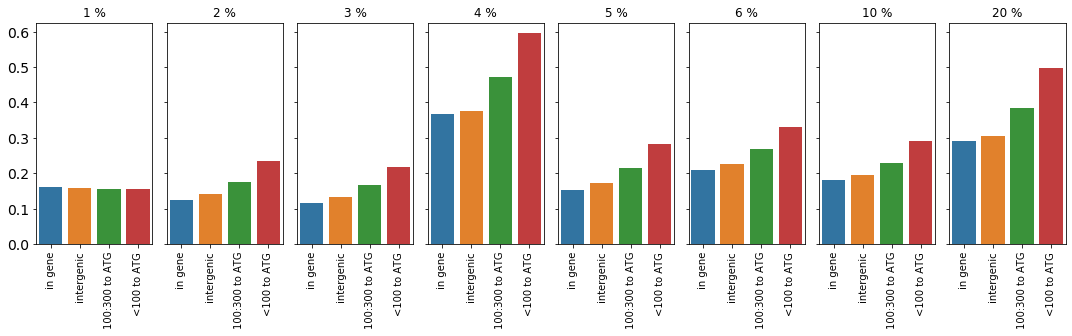

In [26]:
# all pssm matches
compare_genome_cat_enrichment(all_motif_match_cat_df)

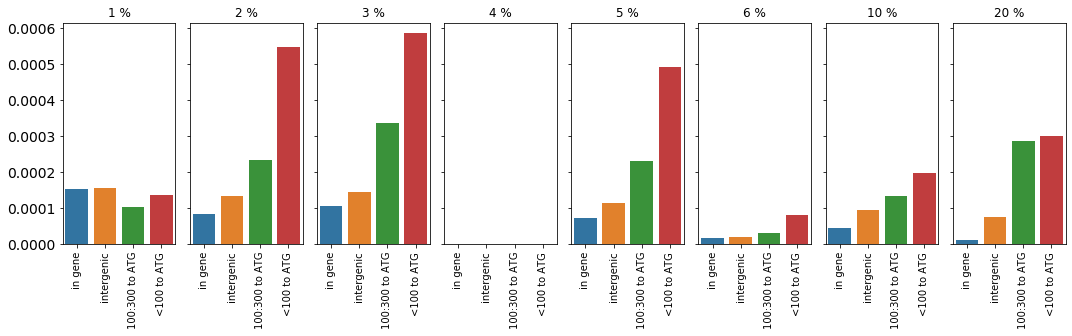

In [27]:
# high scoring pssm above 12
compare_genome_cat_enrichment(all_top_motif_match_cat_df)

Side by side, we can see for which percentage thresholds there was strong enrichment of the consensus in sequences regions immediately upstream of annotated features. Notably, the consensus derived from the top 4% seems like an anomly: the hexamer match to its own inputs is lower, and the overall information content of the consensus is lower than the consensus for 3% and 5%. Due to this low information content, its more generic, so it finds more matches, however this also leads to fewer strong matches. In fact, there were no sequence matches in the genome that even reached a 12 log odds score. 

Otherwise, the consensus motif for the top 2% and 3% of genes seems to be the strongest candidate promoter signal demonstrating upstream enrichement. 